## About the dataset

**carat**: Weight of the diamond (continuous) - *Numeric*  
**cut**: Quality of the cut (Fair → Ideal) -	*Categorical*  
**colorDiamond**: Color, from J (worst) to D (best) - *Categorical*  
**clarity**: Clarity grade (I1 worst → IF best) - *Categorical*  
**depth**: Total depth percentage (z / mean(x, y)) - *Numeric*  
**table**: Width of the top of the diamond	- *Numeric*  
**price**: Price in US dollars - *Numeric*  
**x, y, z**: Dimensions in mm (length, width, depth) - *Numeric*  

In [3]:
import seaborn as sns
import os
os.environ["OMP_NUM_THREADS"] = "1"

# See available datasets
print(sns.get_dataset_names())

# Load one
df_diamonds = sns.load_dataset('diamonds')

df_diamonds.head()
df_diamonds.info()

['anagrams', 'anscombe', 'attention', 'brain_networks', 'car_crashes', 'diamonds', 'dots', 'dowjones', 'exercise', 'flights', 'fmri', 'geyser', 'glue', 'healthexp', 'iris', 'mpg', 'penguins', 'planets', 'seaice', 'taxis', 'tips', 'titanic']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB


In [4]:
missing_percentage = (df_diamonds.isnull().sum() / len(df_diamonds)) * 100

for column, percentage in missing_percentage.items():
    if percentage > 20:
        print(f"\033[91m\033[1m{column}: {percentage:.2f}% missing\033[0m")
    elif percentage > 5:
        print(f"\033[93m{column}: {percentage:.2f}% missing\033[0m")
    elif percentage > 0.00:
        print(f"\033[92m{column}: {percentage:.2f}% missing\033[0m")
    else:
        print(f"{column}: {percentage:.2f}% missing")
    

carat: 0.00% missing
cut: 0.00% missing
color: 0.00% missing
clarity: 0.00% missing
depth: 0.00% missing
table: 0.00% missing
price: 0.00% missing
x: 0.00% missing
y: 0.00% missing
z: 0.00% missing


In [5]:
dupes = df_diamonds.duplicated().sum()
print(dupes)

146


In [6]:
import plotly.express as px
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

df_encoded = df_diamonds.copy()

# Ordinal encoding
clarity_order = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
cut_order = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}

df_encoded['clarity'] = df_encoded['clarity'].map(clarity_order)
df_encoded['cut'] = df_encoded['cut'].map(cut_order)


df_encoded = pd.get_dummies(df_encoded, columns=['color'], prefix='color')

#Standardize the price
scaler = StandardScaler()
df_encoded["price_scaled"] = scaler.fit_transform(df_encoded[["price"]])
df_features = df_encoded.drop(columns=["price"])

df_features.drop(columns=["x", "y", "z"], inplace=True)
df_features.head()

,carat,cut,clarity,depth,table,color_D,color_E,color_F,color_G,color_H,color_I,color_J,price_scaled
0,0.23,4,1,61.5,55.0,False,True,False,False,False,False,False,-0.904095
1,0.21,3,2,59.8,61.0,False,True,False,False,False,False,False,-0.904095
2,0.23,1,4,56.9,65.0,False,True,False,False,False,False,False,-0.903844
3,0.29,3,3,62.4,58.0,False,False,False,False,False,True,False,-0.902090
4,0.31,1,1,63.3,58.0,False,False,False,False,False,False,True,-0.901839


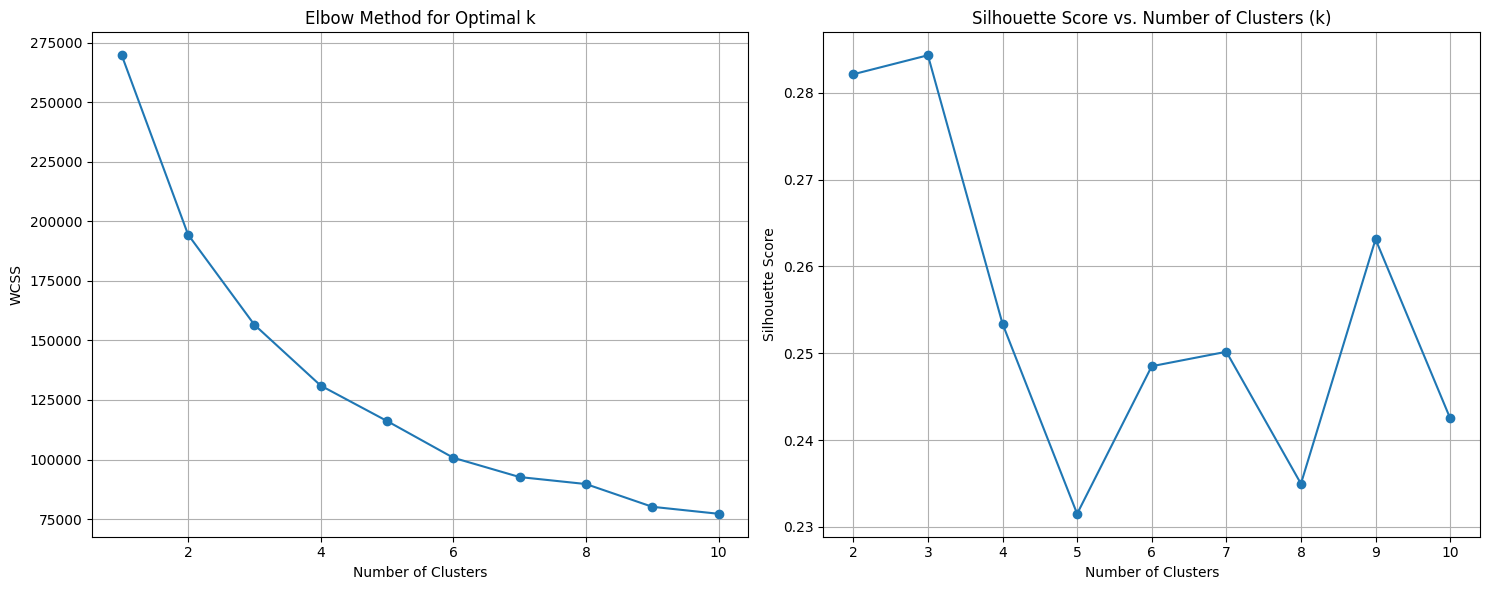

In [7]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Scale the features
X_clusterering_one = df_features[["carat", "depth", "price_scaled", "clarity", "cut"]]

X_scaled = scaler.fit_transform(X_clusterering_one)

# Decide on the number of clusters
wcss = []
scores = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    if i > 1:  # Silhouette score is not defined for 1 cluster
        labels = kmeans.predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        scores.append(score)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot Elbow Method
axes[0].plot(range(1, 11), wcss, marker='o')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('WCSS')
axes[0].grid(True)

# Plot Silhouette Score (only for k > 1)
axes[1].plot(range(2, 11), scores, marker='o')
axes[1].set_title('Silhouette Score vs. Number of Clusters (k)')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [8]:
kmeans = KMeans(n_clusters=3, random_state=42)

df_kmeans = df_features.copy()

df_kmeans['Cluster'] = kmeans.fit_predict(X_scaled)

print(df_kmeans['Cluster'].unique())

df_kmeans.head()

[0 1 2]


,carat,cut,clarity,depth,table,color_D,color_E,color_F,color_G,color_H,color_I,color_J,price_scaled,Cluster
0,0.23,4,1,61.5,55.0,False,True,False,False,False,False,False,-0.904095,0
1,0.21,3,2,59.8,61.0,False,True,False,False,False,False,False,-0.904095,0
2,0.23,1,4,56.9,65.0,False,True,False,False,False,False,False,-0.903844,0
3,0.29,3,3,62.4,58.0,False,False,False,False,False,True,False,-0.902090,0
4,0.31,1,1,63.3,58.0,False,False,False,False,False,False,True,-0.901839,1


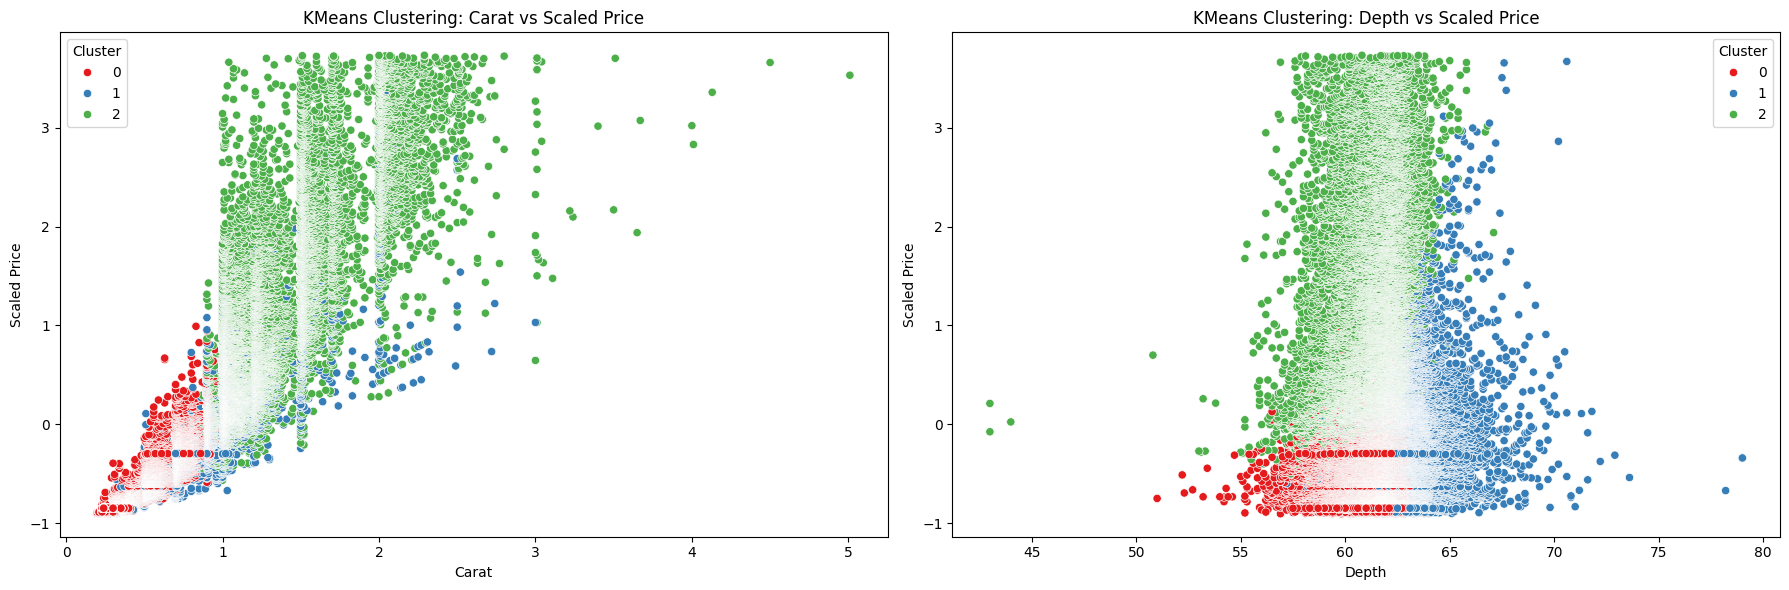

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Scatterplot for 'carat' vs 'price_scaled'
sns.scatterplot(
    data=df_kmeans, 
    x='carat', 
    y='price_scaled', 
    hue='Cluster', 
    palette='Set1', 
    ax=axes[0]
)
axes[0].set_title('KMeans Clustering: Carat vs Scaled Price')
axes[0].set_xlabel('Carat')
axes[0].set_ylabel('Scaled Price')
axes[0].legend(title='Cluster')

# Scatterplot for 'depth' vs 'price_scaled'
sns.scatterplot(
    data=df_kmeans, 
    x='depth', 
    y='price_scaled', 
    hue='Cluster', 
    palette='Set1', 
    ax=axes[1]
)
axes[1].set_title('KMeans Clustering: Depth vs Scaled Price')
axes[1].set_xlabel('Depth')
axes[1].set_ylabel('Scaled Price')
axes[1].legend(title='Cluster')

# Adjust layout
plt.tight_layout()
plt.show()

In [10]:
from sklearn.decomposition import PCA

df_pca_kmeans = df_features.copy()
X_scaled_pca = scaler.fit_transform(df_pca_kmeans)

kmeans_pca = KMeans(n_clusters=3, random_state=42)
clusters_pca = kmeans_pca.fit_predict(X_scaled_pca)

pca = PCA(n_components=2)

X_pca_kmeans = pca.fit_transform(X_scaled_pca)
df_pca_kmeans['Cluster'] = clusters_pca
df_pca_kmeans.head()


,carat,cut,clarity,depth,table,color_D,color_E,color_F,color_G,color_H,color_I,color_J,price_scaled,Cluster
0,0.23,4,1,61.5,55.0,False,True,False,False,False,False,False,-0.904095,1
1,0.21,3,2,59.8,61.0,False,True,False,False,False,False,False,-0.904095,1
2,0.23,1,4,56.9,65.0,False,True,False,False,False,False,False,-0.903844,1
3,0.29,3,3,62.4,58.0,False,False,False,False,False,True,False,-0.902090,1
4,0.31,1,1,63.3,58.0,False,False,False,False,False,False,True,-0.901839,1


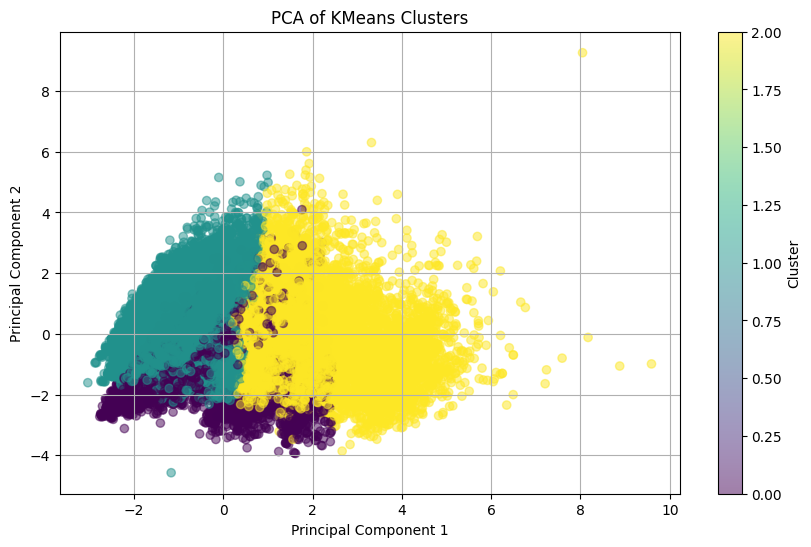

Silhouette Score for PCA: 0.13


In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(X_pca_kmeans[:, 0], X_pca_kmeans[:, 1], c=clusters_pca, cmap='viridis', alpha=0.5)
plt.title('PCA of KMeans Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

score_pca = silhouette_score(X_scaled_pca, clusters_pca)
print(f"Silhouette Score for PCA: {score_pca:.2f}")

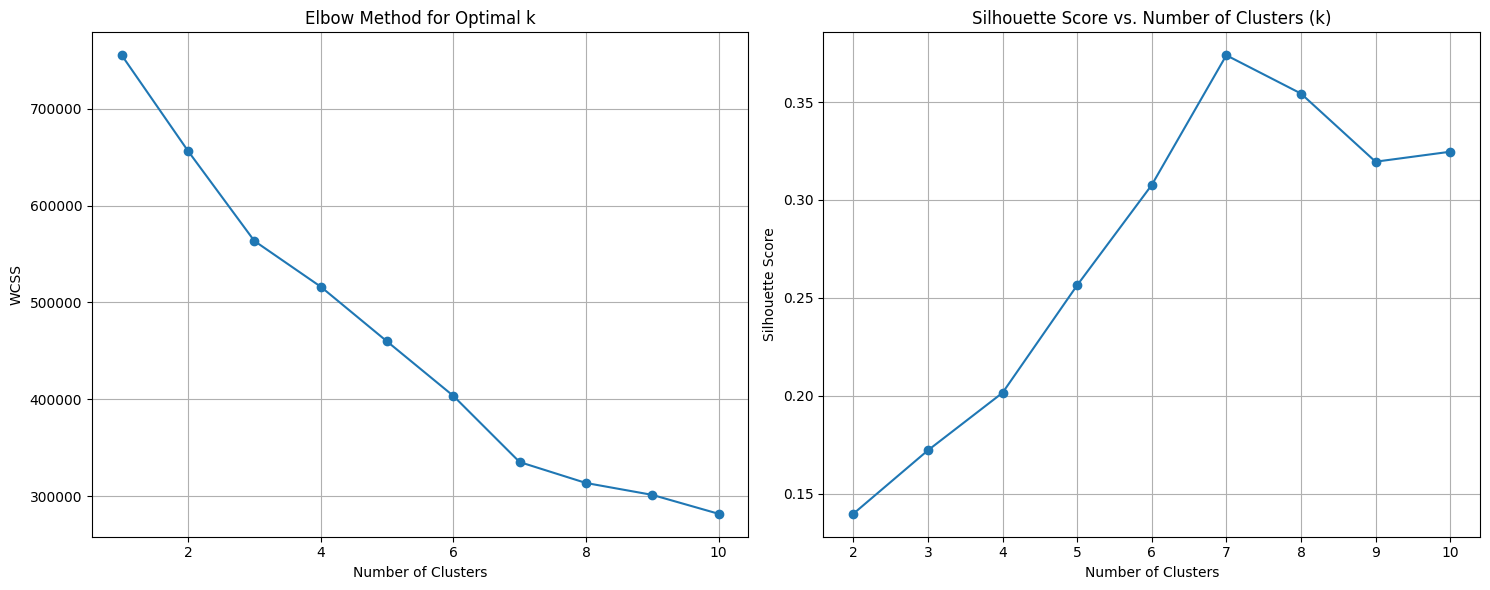

In [12]:
# Scale the features
X_scaled_pca = scaler.fit_transform(df_pca_kmeans)

# Decide on the number of clusters
wcss = []
scores = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled_pca)
    wcss.append(kmeans.inertia_)
    if i > 1:  # Silhouette score is not defined for 1 cluster
        labels = kmeans.predict(X_scaled_pca)
        score = silhouette_score(X_scaled_pca, labels)
        scores.append(score)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot Elbow Method
axes[0].plot(range(1, 11), wcss, marker='o')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('WCSS')
axes[0].grid(True)

# Plot Silhouette Score (only for k > 1)
axes[1].plot(range(2, 11), scores, marker='o')
axes[1].set_title('Silhouette Score vs. Number of Clusters (k)')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [13]:
df_pca_kmeans = df_features.copy()
X_scaled_pca = scaler.fit_transform(df_pca_kmeans)

kmeans_pca = KMeans(n_clusters=7, random_state=42)
clusters_pca = kmeans_pca.fit_predict(X_scaled_pca)

pca = PCA(n_components=2)

X_pca_kmeans = pca.fit_transform(X_scaled_pca)
df_pca_kmeans['Cluster'] = clusters_pca
df_pca_kmeans.head()


,carat,cut,clarity,depth,table,color_D,color_E,color_F,color_G,color_H,color_I,color_J,price_scaled,Cluster
0,0.23,4,1,61.5,55.0,False,True,False,False,False,False,False,-0.904095,4
1,0.21,3,2,59.8,61.0,False,True,False,False,False,False,False,-0.904095,4
2,0.23,1,4,56.9,65.0,False,True,False,False,False,False,False,-0.903844,4
3,0.29,3,3,62.4,58.0,False,False,False,False,False,True,False,-0.902090,6
4,0.31,1,1,63.3,58.0,False,False,False,False,False,False,True,-0.901839,6


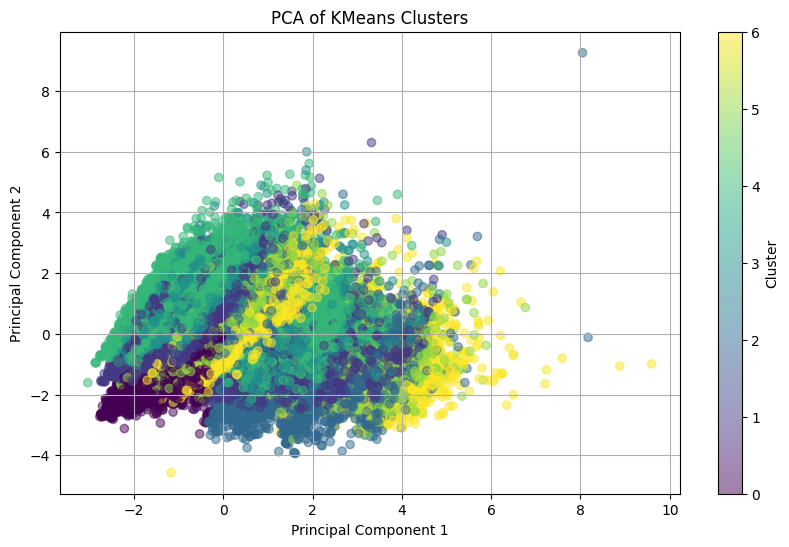

Silhouette Score for PCA: 0.29


In [14]:

plt.figure(figsize=(10, 6))
plt.scatter(X_pca_kmeans[:, 0], X_pca_kmeans[:, 1], c=clusters_pca, cmap='viridis', alpha=0.5)
plt.title('PCA of KMeans Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

score_pca = silhouette_score(X_scaled_pca, clusters_pca)
print(f"Silhouette Score for PCA: {score_pca:.2f}")

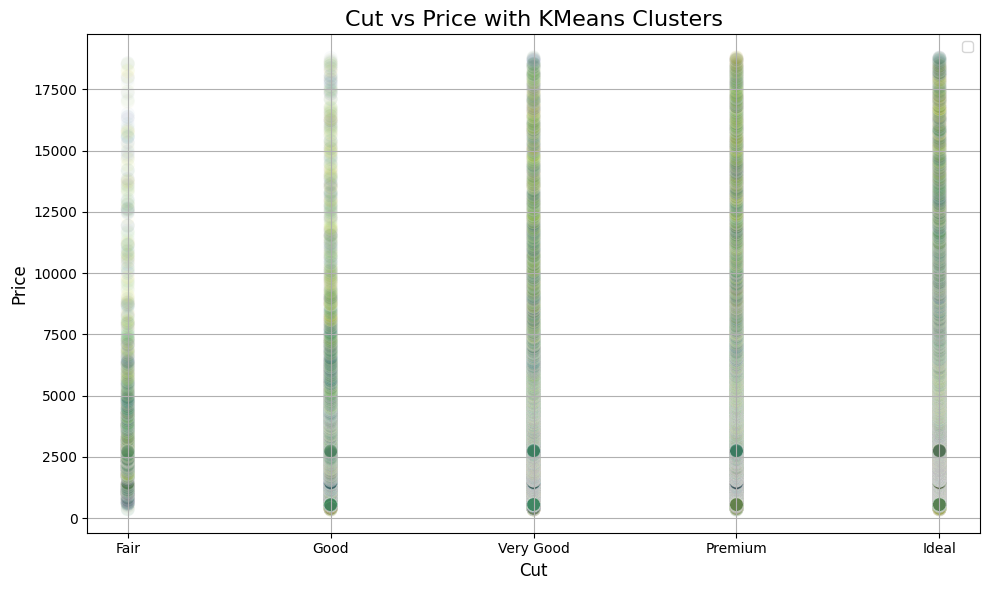

In [75]:

# Kontrollera och konvertera 'cut' till kategorisk
df_diamonds['cut'] = pd.Categorical(df_diamonds['cut'], categories=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], ordered=True)

# Lägg till klusteretiketter i df_diamonds
df_diamonds['Cluster'] = clusters_pca

# Skapa scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_diamonds, x='cut', y='price', hue=clusters_pca, palette='viridis', alpha=0.03, s=100)

# Anpassa diagrammet
plt.title('Cut vs Price with KMeans Clusters', fontsize=16)
plt.xlabel('Cut', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True)
plt.legend("")

# Visa diagrammet
plt.tight_layout()
plt.show()

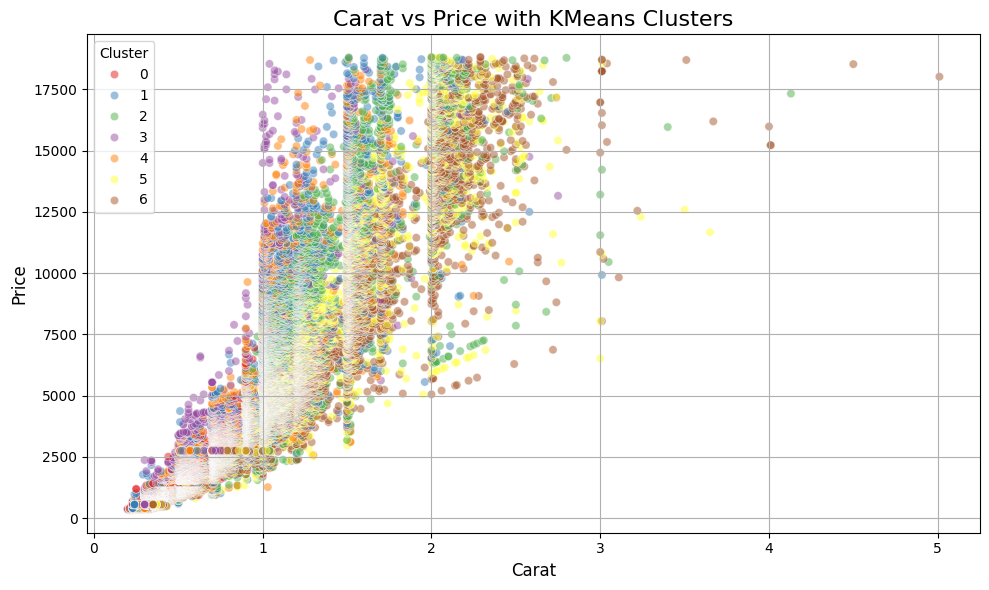

In [117]:
# Lägg till klusteretiketter från PCA-klustring i originaldatasetet
df_diamonds['Cluster'] = clusters_pca

# Skapa scatterplot med 'carat' på x-axeln och 'price' på y-axeln
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_diamonds, x='carat', y='price', hue='Cluster', palette='Set1', alpha=0.5)

# Anpassa diagrammet
plt.title('Carat vs Price with KMeans Clusters', fontsize=16)
plt.xlabel('Carat', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True)

# Visa diagrammet
plt.tight_layout()
plt.show()

In [15]:
import umap

X_scaled_umap = scaler.fit_transform(df_features)

#Applicera UMAP
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
X_umap = umap_reducer.fit_transform(X_scaled_umap)

#Skapa en dataframe för UMAP-resultat
df_umap = pd.DataFrame (X_umap, columns=['UMAP1', 'UMAP2'])

kmeans_umap = KMeans(n_clusters=7, random_state=42) 
df_umap['Cluster'] = kmeans.fit_predict(X_umap)

df_umap.head()

c:\Users\Nikla\OneDrive\AI developer\Tillämpad_AI\Programmering\gruppuppgifter\uppgift_4\EDA_Unsupervised-Learning\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Nikla\OneDrive\AI developer\Tillämpad_AI\Programmering\gruppuppgifter\uppgift_4\EDA_Unsupervised-Learning\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,UMAP1,UMAP2,Cluster
0,12.927078,-4.969693,1
1,12.776960,-0.836653,1
2,9.091757,3.884815,9
3,12.671677,10.437200,3
4,8.798856,14.265039,6


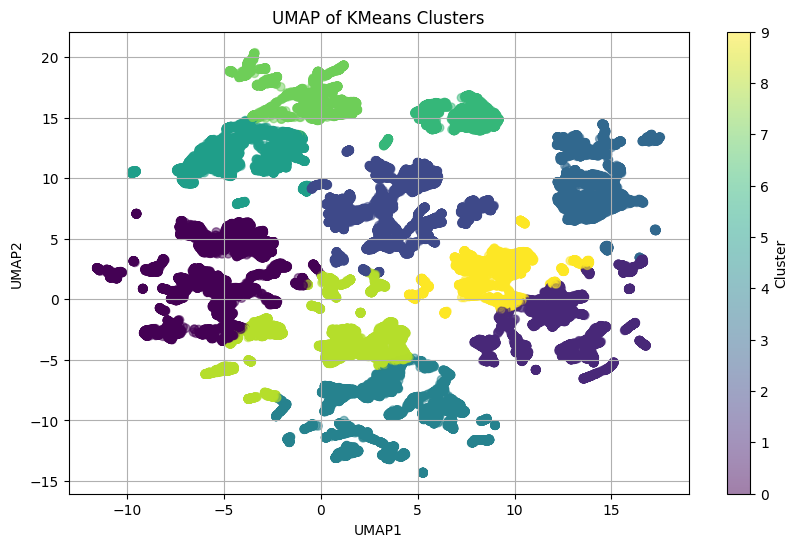

0.20165060943802854


In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(df_umap['UMAP1'], df_umap['UMAP2'], c=df_umap['Cluster'], cmap='viridis', alpha=0.5)
plt.title('UMAP of KMeans Clusters')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()
score_umap = silhouette_score(X_scaled_umap, df_umap['Cluster'])
print(score_umap)

In [17]:
from scipy.stats import shapiro

# Utför Shapiro-Wilk-testet
stat, p = shapiro(df_diamonds['price'])

# Kontrollera resultatet och skriv ut korrekt meddelande
if p < 0.05:
    print(f"The data is not normally distributed (p = {p:.5f}).")
else:
    print(f"The data is normally distributed (p = {p:.5f}).")

# Skriv ut teststatistiken
print(f"Shapiro-Wilk test statistic: {stat:.5f}")

The data is not normally distributed (p = 0.00000).
Shapiro-Wilk test statistic: 0.79810


c:\Users\Nikla\OneDrive\AI developer\Tillämpad_AI\Programmering\gruppuppgifter\uppgift_4\EDA_Unsupervised-Learning\venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 53940.
  res = hypotest_fun_out(*samples, **kwds)


In [18]:

from scipy.stats import chi2_contingency

# Skapa kategorier för 'price' genom att dela in den i kvantiler
df_diamonds['price_category'] = pd.qcut(df_diamonds['price'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Skapa en kontingenstabell mellan 'depth' och 'price_category'
contingency_table = pd.crosstab(df_diamonds['depth'], df_diamonds['price_category'])

# Utför Chi-Square-testet
chi_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Skriv ut resultaten
print("Chi-Square Test Results:")
print(f"Chi-Square Statistic: {chi_stat:.2f}")
print(f"P-value: {p_value:.5f}")
print(f"Degrees of Freedom: {dof}")
print("\nExpected Frequencies:")
print(expected)

# Tolka resultatet
if p_value < 0.05:
    print("\nThere is a significant association between 'price' and 'depth' (p < 0.05).")
else:
    print("\nThere is no significant association between 'price' and 'depth' (p >= 0.05).")

Chi-Square Test Results:
Chi-Square Statistic: 1842.26
P-value: 0.00000
Degrees of Freedom: 549

Expected Frequencies:
[[5.00185391e-01 5.00370782e-01 4.99443826e-01 5.00000000e-01]
 [2.50092696e-01 2.50185391e-01 2.49721913e-01 2.50000000e-01]
 [2.50092696e-01 2.50185391e-01 2.49721913e-01 2.50000000e-01]
 [2.50092696e-01 2.50185391e-01 2.49721913e-01 2.50000000e-01]
 [2.50092696e-01 2.50185391e-01 2.49721913e-01 2.50000000e-01]
 [2.50092696e-01 2.50185391e-01 2.49721913e-01 2.50000000e-01]
 [2.50092696e-01 2.50185391e-01 2.49721913e-01 2.50000000e-01]
 [2.50092696e-01 2.50185391e-01 2.49721913e-01 2.50000000e-01]
 [2.50092696e-01 2.50185391e-01 2.49721913e-01 2.50000000e-01]
 [5.00185391e-01 5.00370782e-01 4.99443826e-01 5.00000000e-01]
 [2.50092696e-01 2.50185391e-01 2.49721913e-01 2.50000000e-01]
 [2.50092696e-01 2.50185391e-01 2.49721913e-01 2.50000000e-01]
 [2.50092696e-01 2.50185391e-01 2.49721913e-01 2.50000000e-01]
 [2.50092696e-01 2.50185391e-01 2.49721913e-01 2.50000000e-01]

C:\Users\Nikla\AppData\Local\Temp\ipykernel_19700\2916807640.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = diamonds.groupby('cut').mean(numeric_only=True)


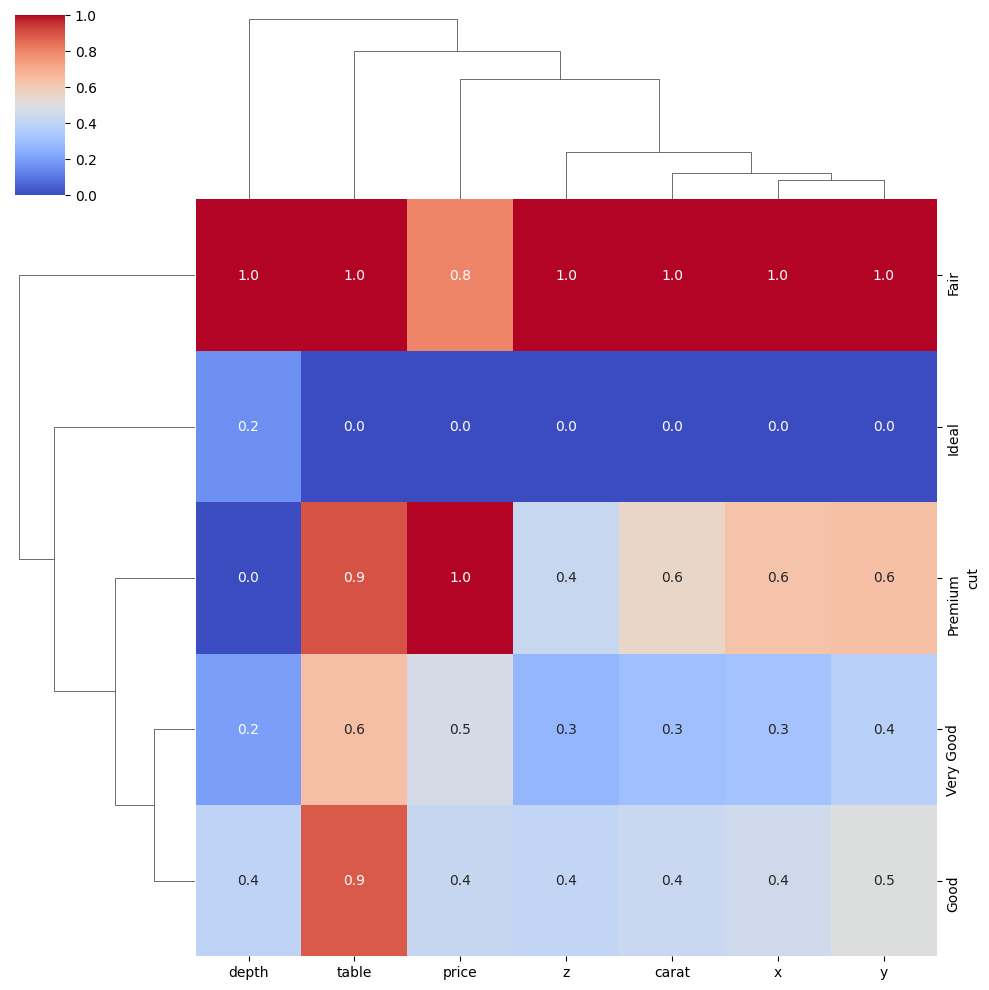

C:\Users\Nikla\AppData\Local\Temp\ipykernel_19700\2916807640.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = diamonds.groupby('color').mean(numeric_only=True)


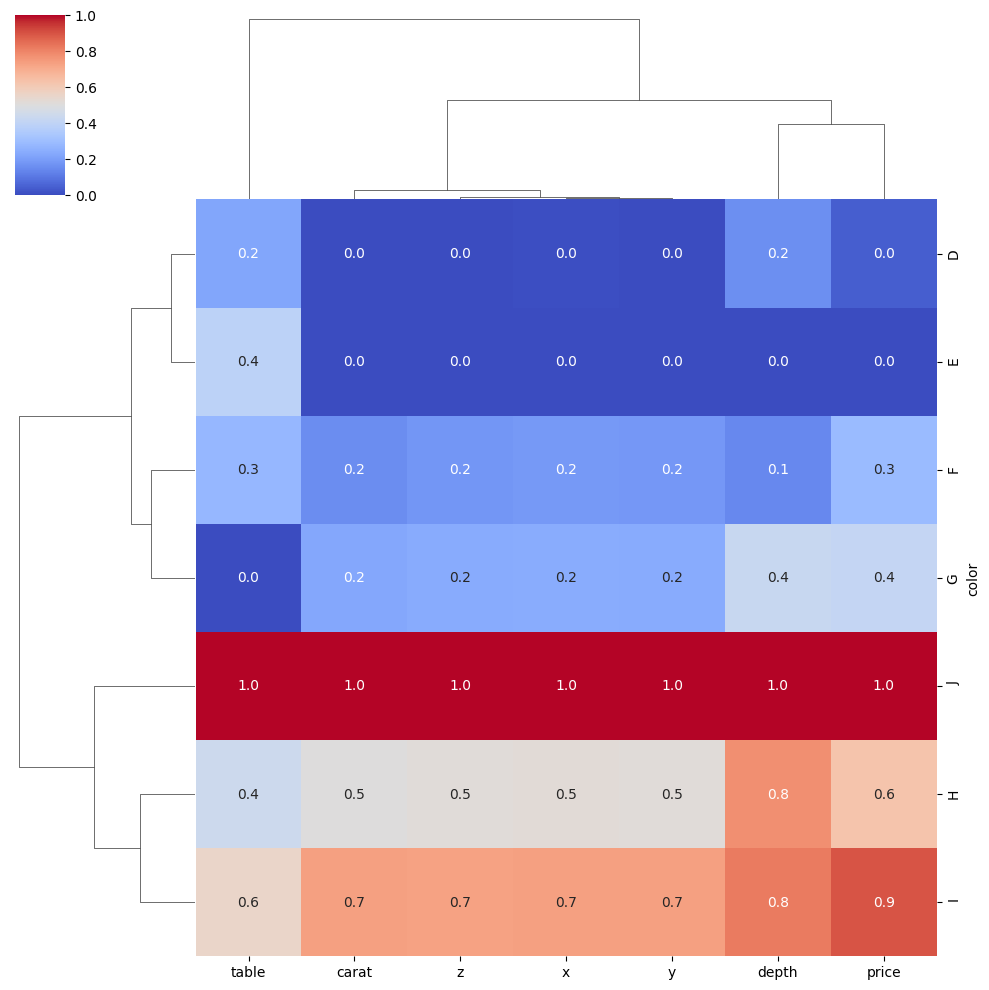

In [19]:
# Ladda diamonds-datasetet
diamonds = sns.load_dataset('diamonds')

# Gruppera efter 'cut' och beräkna medelvärden på numeriska kolumner
grouped = diamonds.groupby('cut').mean(numeric_only=True)

# Skapa en clustermap där rader är olika 'cut'-kategorier
sns.clustermap(grouped, cmap='coolwarm', standard_scale=1, annot=True, fmt=".1f")

plt.show()

# Gruppera efter 'cut' och beräkna medelvärden på numeriska kolumner
grouped = diamonds.groupby('color').mean(numeric_only=True)

# Skapa en clustermap där rader är olika 'cut'-kategorier
sns.clustermap(grouped, cmap='coolwarm', standard_scale=1, annot=True, fmt=".1f")

plt.show()


C:\Users\Nikla\AppData\Local\Temp\ipykernel_19700\2295871472.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=diamonds, x='color', palette='Set2')


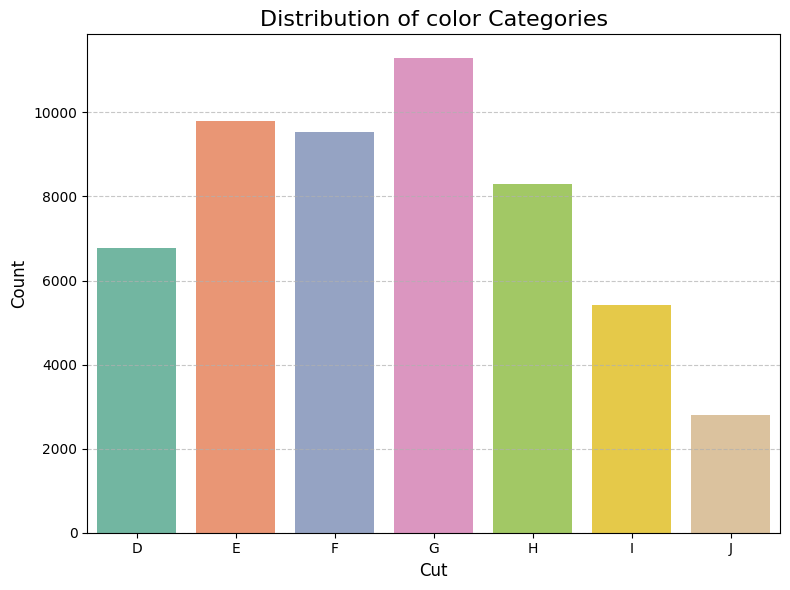

In [20]:
diamonds = sns.load_dataset('diamonds')

# Skapa ett stapeldiagram för fördelningen av 'color'
plt.figure(figsize=(8, 6))
sns.countplot(data=diamonds, x='color', palette='Set2')

# Anpassa diagrammet
plt.title('Distribution of color Categories', fontsize=16)
plt.xlabel('Cut', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Visa diagrammet
plt.tight_layout()
plt.show()

C:\Users\Nikla\AppData\Local\Temp\ipykernel_19700\2271867407.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=diamonds, x='cut', palette='Set2')


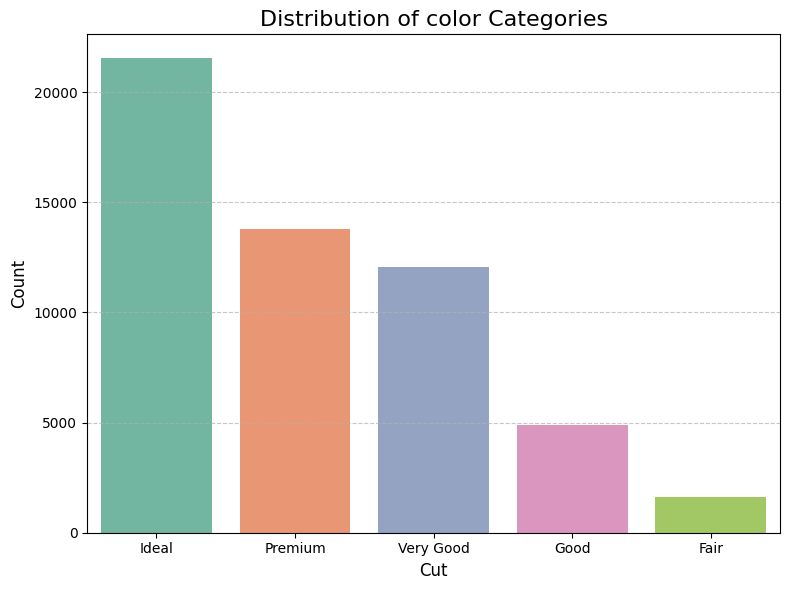

In [21]:
diamonds = sns.load_dataset('diamonds')

# Skapa ett stapeldiagram för fördelningen av 'color'
plt.figure(figsize=(8, 6))
sns.countplot(data=diamonds, x='cut', palette='Set2')

# Anpassa diagrammet
plt.title('Distribution of color Categories', fontsize=16)
plt.xlabel('Cut', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Visa diagrammet
plt.tight_layout()
plt.show()